In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.sparse import csr_matrix
from itertools import permutations
from sklearn.preprocessing import normalize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

In [2]:
X = pd.read_csv("train_values.csv")
y = pd.read_csv("train_labels.csv")

Just to be sure that each `sequence_id` has only one origin, the congruence of the one-hot encoded sums will be checked agains the number of rows of the dataset

In [64]:
y_sums = y.sum(axis=1).values
sum(y_sums) == y.shape[0]

True

The training labels need to be collapsed from their sparse matrix format

In [3]:
lab_ids = y.columns[1:]
# get numpy matrix of lab_id one-hot values
lab_matrix = y.drop(columns=['sequence_id']).values
# get array of indices to map back to lab_ids
lab_col_indices = np.asarray(lab_matrix == 1).nonzero()[1]

y['lab_id'] = lab_ids[lab_col_indices]
lbls = y
y = y[['sequence_id', 'lab_id']]

In [66]:
# verify that all labels are correct
def correct_label(row_n):
    return lbls.iloc[row_n][lbls['lab_id'].iloc[row_n]] == 1

all(list(map(correct_label, range(lbls.shape[0]))))

True

In [93]:
# what are the proportions of the classes?
y['lab_id'].value_counts(normalize=True).head()

I7FXTVDP    0.131488
RKJHZGDQ    0.043353
GTVTUGVY    0.042401
A18S09P2    0.016884
Q2K8NHZY    0.015440
Name: lab_id, dtype: float64

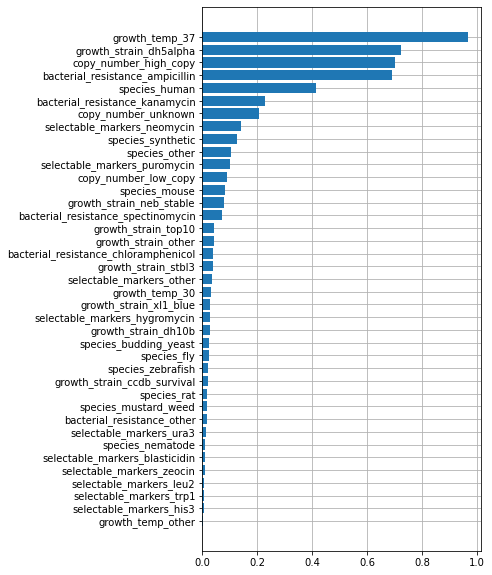

In [7]:
# what are the most prevalent binary features?
column_names = X.iloc[:, 2:].mean().sort_values(ascending=True).index
feature_props = X.iloc[:, 2:].mean().sort_values(ascending=True).values

plt.figure(figsize=(5, 10))
plt.grid(b=True)
plt.barh(np.arange(len(column_names)), feature_props, zorder=2)
plt.yticks(range(len(column_names)), labels=column_names)
plt.show()

Cross validation would be a useful technique, but there are classes where there are less than 5 members. we'll try to over-sample the underrepresented classes

In [4]:
# these are the classes with less than 5 members
# need all to have at least 5 for randomized search cv
print(y['lab_id'].value_counts().tail(19))

# create resampling map
resample_map = y['lab_id'].value_counts().tail(19)
resample_map = list(zip(resample_map.index, resample_map.values))

XCWSW5T9    4
YCD71LRY    4
LGTP4O86    4
UMOD7PGG    4
INDCDVP0    4
1KZHNVYR    4
WM3Q8LBC    4
68OY1RK5    4
RZPGGEG4    4
VDSDXJ71    4
03GRNN7N    4
PXT3AJ7C    4
8N5EPD5C    4
W2DYAZID    4
G2P73NZ0    3
58BSUZQB    3
WB78G3XF    2
ON9AXMKF    1
0L3Y6ZB2    1
Name: lab_id, dtype: int64


In order to oversample the underrepresented classes, we need to add the lab id's back into the feature matrix

In [5]:
over_samp = pd.concat([X, y['lab_id']], axis=1)
over_samp.head()

,sequence_id,sequence,bacterial_resistance_ampicillin,bacterial_resistance_chloramphenicol,bacterial_resistance_kanamycin,bacterial_resistance_other,bacterial_resistance_spectinomycin,copy_number_high_copy,copy_number_low_copy,copy_number_unknown,...,species_fly,species_human,species_mouse,species_mustard_weed,species_nematode,species_other,species_rat,species_synthetic,species_zebrafish,lab_id
0,9ZIMC,CATGCATTAGTTATTAATAGTAATCAATTACGGGGTCATTAGTTCA...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,RYUA3GVO
1,5SAQC,GCTGGATGGTTTGGGACATGTGCAGCCCCGTCTCTGTATGGAGTGA...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,RYUA3GVO
2,E7QRO,NNCCGGGCTGTAGCTACACAGGGCGGAGATGAGAGCCCTACGAAAG...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,RYUA3GVO
3,CT5FP,GCGGAGATGAAGAGCCCTACGAAAGCTGAGCCTGCGACTCCCGCAG...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,RYUA3GVO
4,7PTD8,CGCGCATTACTTCACATGGTCCTCAAGGGTAACATGAAAGTGATCC...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,RYUA3GVO


In [6]:
def oversample(df, resamp_map, min_samps=5):
    """
    Randomly oversample rows that belong to classes with less than N
    members
    
    df: pandas DataFrame object
    resamp_map: reference values for classes and resample amount
    """
    new_df = df.copy()
    for class_, members in resamp_map:
        for i in range(min_samps - members):
            new_row = new_df.loc[new_df['lab_id'] == class_].sample(n=1)
            new_df = new_df.append(new_row)
    
    return new_df

Now the minimum number of members for each class is 5

In [7]:
over_samp = oversample(over_samp, resample_map)
over_samp['lab_id'].value_counts().tail(20)

2JPNC9X6    5
XYB5NWR4    5
BH7HW7XH    5
EJ3T17DB    5
WB78G3XF    5
RZPGGEG4    5
G6MP6EIN    5
LUHRMKEB    5
78QGAL01    5
SBQXQOPV    5
YCD71LRY    5
Z7YFK3I0    5
QYBCIW4J    5
CFOET28L    5
58BSUZQB    5
8N5EPD5C    5
68OY1RK5    5
71R7TM8L    5
MH0GC0GY    5
BV6PVSO5    5
Name: lab_id, dtype: int64

The plan is to extract 4-grams using raw counts from the sequences and concatenate the resulting 
features to the existing binary features. From there the prospective model can fit the entire data
set.

In [8]:
N_GRAMS = 4

# create the 'vocabulary' for the different nucleotides
n_tides = set(''.join(over_samp['sequence'].values))

# create a list of subsequences for features
subseqs = list(''.join(p) for p in permutations(n_tides, r=N_GRAMS))
subseqs[:5]

['ANTG', 'ANTC', 'ANGT', 'ANGC', 'ANCT']

In [9]:
def seq_table(data, seqs):
    """Creates a dataframe based on nucleotide subsequence counts"""
    table = pd.DataFrame(index=data.index)
    for s in seqs:
        table[s] = data['sequence'].str.count(s)
    return table

In [10]:
ngrams = seq_table(over_samp, subseqs)

# concatenate the new dataframe to the existing one
X = pd.concat([over_samp, ngrams], axis=1).drop(columns=['sequence'])
X.head()

,sequence_id,bacterial_resistance_ampicillin,bacterial_resistance_chloramphenicol,bacterial_resistance_kanamycin,bacterial_resistance_other,bacterial_resistance_spectinomycin,copy_number_high_copy,copy_number_low_copy,copy_number_unknown,growth_strain_ccdb_survival,...,CTNA,CTNG,CTGA,CTGN,CGAN,CGAT,CGNA,CGNT,CGTA,CGTN
0,9ZIMC,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0,0,44,0,0,17,0,0,14,0
1,5SAQC,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0,0,6,0,0,0,0,0,0,0
2,E7QRO,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0,0,2,2,1,1,0,0,0,0
3,CT5FP,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0,0,8,0,0,0,0,0,1,0
4,7PTD8,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0,0,4,0,0,1,0,0,2,0


The new data needs to be normalized because of the different scales (binary and counts)

In [12]:
# set y first
y = X['lab_id']

# set X_normalized and convert to compressed sparse matrix
X = X.drop(columns=['lab_id'])

# save the column names for use in permutation importance
column_names = X.iloc[:, 1:].columns
X_normalized = normalize(X.iloc[:, 1:])

In [114]:
# construct the neighbors model
nn_clf = KNeighborsClassifier()

params = {"weights": ["uniform", "distance"],
          "algorithm": ["ball_tree", "kd_tree"],
          "leaf_size": range(20, 60, 10),
          "metric": ["minkowski", "euclidean", "manhattan"],
          "p": [1, 2]}

clf = RandomizedSearchCV(nn_clf, params, random_state=0, verbose=1, n_jobs=-1)
search = clf.fit(X_normalized, y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 24.6min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 28.1min finished
/home/jose/miniconda3/envs/data-gov/lib/python3.7/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "


In [27]:
X_normalized.shape

(63046, 159)

In [30]:
X_train, X_val, y_train, y_val = train_test_split(X_normalized, y, 
                                                  test_size=.20, 
                                                  random_state=0, 
                                                  stratify=y)
print(X_train.shape, X_val.shape)
print(y_train.shape, y_val.shape)

(50436, 159) (12610, 159)
(50436,) (12610,)


In [49]:
nn_classifier = KNeighborsClassifier(weights="distance", algorithm="kd_tree",
                                     metric="manhattan", leaf_size=40, p=1)
nn_classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=40, metric='manhattan', p=1,
                     weights='distance')

In [50]:
nn_classifier.score(X_val, y_val)

0.6805709754163363

In [56]:
def top10_accuracy(estimator, X, y):
    """
    Custom scorer based on competition function.
    Evaluation is based on whether the right label
    is in the top 10 most probable predictions. 
    Adheres to the signature in sklearn documentation
    for scorers
    """
    # get probabilities
    probs = estimator.predict_proba(X)
    
    # get indices for top 10
    top10_idx = np.argpartition(probs, -10, axis=1)[:, -10:]
    
    # get the class names
    top10_preds = estimator.classes_[top10_idx]
    
    # check if correct label is in top 10 for each set of preds
    mask = top10_preds == y.reshape((y.size, 1))
    
    # get the mean
    top_10_accuracy = mask.any(axis=1).mean()
    
    return top_10_accuracy

In [58]:
top10_accuracy(nn_classifier, X_val, y_val.values.ravel())

0.7978588421887391

In [59]:
X_test = pd.read_csv("test_values.csv")

# convert sequences to features
test_ngrams = seq_table(X_test, subseqs)
# concatenate new features
X_test = pd.concat([X_test, test_ngrams], axis=1).drop(columns=['sequence_id', 'sequence'])
# normalize
X_test_normalized = normalize(X_test)

In [60]:
probs = nn_classifier.predict_proba(X_test_normalized)

In [66]:
sub_format = pd.read_csv("submission_format_3TFRxH6.csv", index_col='sequence_id')

assert sub_format.shape == probs.shape
assert (nn_classifier.classes_ == sub_format.columns).all()

In [68]:
submission = pd.DataFrame(data=probs, 
                          columns=nn_classifier.classes_,
                          index=sub_format.index)

In [72]:
submission.to_csv("submission.csv")